<a href="https://colab.research.google.com/github/majdkhalife/StockPredictor/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

They can capture complex patterns and long-term dependencies within the data, making them a valuable approach for stock forecast, although with inherent limitations and the ever-present volatility of the market.

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
stock_data = yf.download("JNJ", start="2000-01-01")
get_stock_data = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed


In [28]:
get_stock_data.head()

Price,Open,Close
Ticker,JNJ,JNJ
Date,,
2000-01-03,46.56250,46.09375
2000-01-04,45.56250,44.40625
2000-01-05,44.40625,44.87500
2000-01-06,45.15625,46.28125
2000-01-07,47.06250,48.25000


Have new dataframe, where date is first column and we only use open and close values for this model.

In [30]:
get_stock_data = get_stock_data.reset_index()
get_stock_data = get_stock_data[["Date","Open", "Close"]]

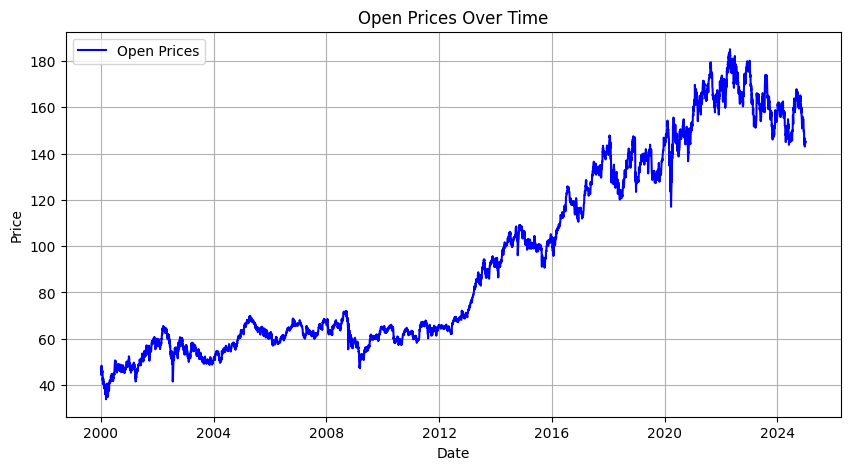

In [38]:
# Plot Open values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data['Date'], get_stock_data["Open"], label="Open Prices", color="blue")
plt.title("Open Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

Next, we pre-process the data. We must transform the values in our data. We do so to bring all price values to a common scale.

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(get_stock_data[["Open", "Close"]])

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data, test_size=0.2, shuffle=False)

LSTM takes sequential data, so we would need to transform our numerical inmputs into sequences.

In [46]:
def create_sequence(data, sequence_length=50):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  # Sequence of past 50 days
        label = data[i + sequence_length]  # Value to predict
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

train_seq, train_label = create_sequence(X_train, sequence_length=50)
test_seq, test_label = create_sequence(X_test, sequence_length=50)

In [49]:
train_seq = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], 2))  # Assuming 2 features (Open, Close)
test_seq = test_seq.reshape((test_seq.shape[0], test_seq.shape[1], 2))

In [51]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=2))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,102 (199.62 KB)

 Trainable params: 51,102 (199.62 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)
test_pred = model.predict(test_seq)
test_inverse_pred = scaler.inverse_transform(test_pred)

Epoch 1/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 0.0173 - val_loss: 0.0015
Epoch 2/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 9.7046e-04 - val_loss: 0.0011
Epoch 3/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 8.3104e-04 - val_loss: 0.0027
Epoch 4/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 8.2284e-04 - val_loss: 0.0040
Epoch 5/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 7.6696e-04 - val_loss: 0.0013
Epoch 6/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 7.0741e-04 - val_loss: 0.0015
Epoch 7/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 6.2066e-04 - val_loss: 8.3219e-04
Epoch 8/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 6.7694e-04 - val_loss: 0.0016
Epoch 9/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - loss: 6.9723e-04 - val_loss: 7.3448e-04
Epoch 10/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - loss: 5.8090e-04 - val_loss: 0.0010
Epoch 11/80
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 5.2590e-04 -

In [55]:
stock_pred_data = get_stock_data.iloc[-len(test_pred):]
stock_pred_data['Predicted_Open'] = test_inverse_pred[:, 0]
stock_pred_data['Predicted_Close'] = test_inverse_pred[:, 1]

<ipython-input-55-8c221625f9b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_pred_data['Predicted_Open'] = test_inverse_pred[:, 0]
<ipython-input-55-8c221625f9b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_pred_data['Predicted_Close'] = test_inverse_pred[:, 1]


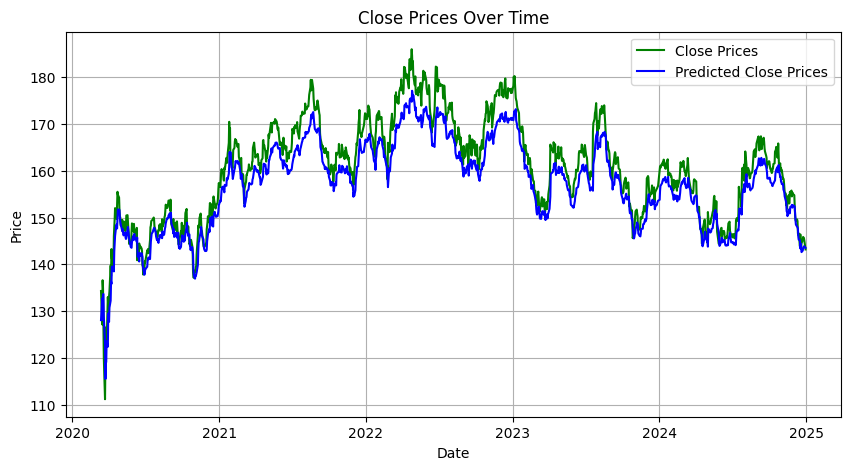

In [62]:
# Plot Close values
plt.figure(figsize=(10, 5))
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Close"]):], get_stock_data["Close"][-len(stock_pred_data["Predicted_Close"]):], label="Close Prices", color="green")
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Close"]):], stock_pred_data["Predicted_Close"], label="Predicted Close Prices", color="blue") # Changed label for clarity
plt.title("Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

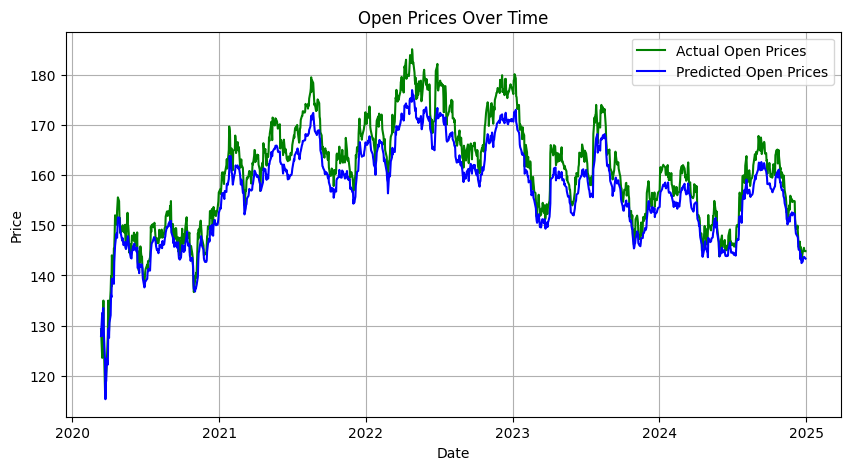

In [64]:
# Plot Open values
plt.figure(figsize=(10, 5))
# Plot Actual Open Prices
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Open"]):],get_stock_data["Open"][-len(stock_pred_data["Predicted_Open"]):], label="Actual Open Prices", color="green")
# Plot Predicted Open Prices
plt.plot(get_stock_data["Date"][-len(stock_pred_data["Predicted_Open"]):], stock_pred_data["Predicted_Open"], label="Predicted Open Prices", color="blue")
plt.title("Open Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()